In [1]:
from deap import base, creator, tools, algorithms
import numpy as np
import pandas as pd
import random

In [2]:
# Load data
MAX_WEIGHT = 6404180

weights = profits = []

with open('p08_w.txt') as w_file:
  weights = w_file.readlines()

with open('p08_p.txt') as p_file:
  profits = p_file.readlines()

weights = [int(x.strip()) for x in weights]
profits = [int(x.strip()) for x in profits]

data = pd.DataFrame({'weight': weights, 'profit': profits})
count = data.count()
assert count[0] == count[1]
N = data.count()[0]
print(f'There are {N} items to choose')
data.head()

There are 24 items to choose


,weight,profit
0,382745,825594
1,799601,1677009
2,909247,1676628
3,729069,1523970
4,467902,943972


In [3]:
# Define evaluation function. 
# In case that the sum of the weights is greater than the maximum weight, profit is zero.

def func_eval(ind, ):
  weight = data.weight[ind].sum()
  if weight > MAX_WEIGHT:
    return 0,
  return data.profit[ind].sum(),

In [4]:
toolbox = base.Toolbox()

toolbox.register('select', tools.selRoulette)
toolbox.register('mate', tools.cxOnePoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.1)
toolbox.register('evaluate', func_eval)

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox.register('bit', random.choice, seq=[True, False])
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.bit, n=24)


toolbox.register('population', tools.initRepeat, list, toolbox.individual)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register('min', np.min)
stats.register('max', np.max)
stats.register('mean', np.mean)
stats.register('std', np.std)
stats.register('median', np.median)

pop = toolbox.population(n=20)

hof = tools.HallOfFame(3)


In [10]:

population, log = algorithms.eaSimple(pop, toolbox, cxpb=0.1, mutpb=0.1, ngen=100, stats=stats, halloffame=hof)
log = pd.DataFrame(log)
log.tail()
# print(hof)

gen	nevals	min	max        	mean       	std        	median     
0  	0     	0  	1.28093e+07	1.17793e+07	2.74412e+06	1.25734e+07
1  	2     	0  	1.28093e+07	1.18391e+07	2.75834e+06	1.28093e+07
2  	4     	1.01857e+07	1.28093e+07	1.23026e+07	710243     	1.27112e+07
3  	3     	1.01857e+07	1.28093e+07	1.20679e+07	729235     	1.21477e+07
4  	1     	1.14861e+07	1.28093e+07	1.23171e+07	564580     	1.27112e+07
5  	2     	1.14861e+07	1.28093e+07	1.21995e+07	602314     	1.23375e+07
6  	7     	0          	1.28093e+07	1.16495e+07	2.74607e+06	1.23375e+07
7  	3     	0          	1.28093e+07	1.1531e+07 	2.70152e+06	1.23375e+07
8  	6     	1.13935e+07	1.28093e+07	1.2411e+07 	512826     	1.27112e+07
9  	6     	0          	1.28093e+07	1.10826e+07	3.72896e+06	1.25244e+07
10 	2     	1.14861e+07	1.28093e+07	1.21599e+07	493883     	1.20987e+07
11 	0     	1.14861e+07	1.28093e+07	1.23584e+07	513151     	1.27112e+07
12 	4     	1.03201e+07	1.28093e+07	1.22823e+07	638351     	1.25244e+07
13 	3     	1.14861e+07	1.28093

,gen,nevals,min,max,mean,std,median
96,96,2,0.0,12722018.0,11591154.3,2.755865e+06,12624592.0
97,97,5,0.0,12791684.0,11616438.2,2.771463e+06,12673305.0
98,98,5,0.0,12791684.0,10323127.7,4.407470e+06,12624592.0
99,99,3,10077237.0,12791684.0,12446589.1,7.326220e+05,12722018.0
100,100,5,0.0,12791684.0,11637506.7,2.840872e+06,12722018.0


In [6]:
import matplotlib.pyplot as plt


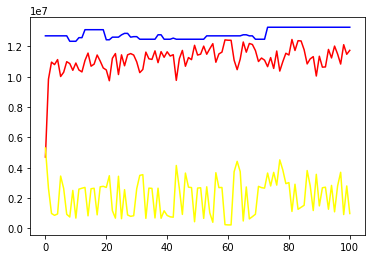

In [7]:

plt.plot(log['gen'], log['mean'], color='red')
plt.plot(log['gen'], log['max'], color='blue')
plt.plot(log['gen'], log['std'], color='yellow')
plt.show()